In [1]:
! pip install fastmri sigpy pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.6/385.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.5 MB/s eta 0:00:00


## Let's use sigpy

In [4]:
import fastmri
from fastmri.data.subsample import EquispacedMaskFractionFunc, create_mask_for_mask_type
from fastmri.data import transforms as T
from sigpy.mri.app import EspiritCalib as Espirit
import numpy as np
import sigpy as sp
import h5py as h5
import matplotlib.pyplot as plt
import cv2

 Args:
 
        * ksp (array): k-space array of shape [num_coils, n_ndim, ..., n_1]

        * calib (tuple of ints): length-2 image shape.

        * thresh (float): threshold for the calibration matrix.

        * kernel_width (int): kernel width for the calibration matrix.

        * max_power_iter (int): maximum number of power iterations.

        * device (Device): computing device.
        
        * crop (int): cropping threshold.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
def save(ground_truth: np.ndarray, csm: np.ndarray, mask: np.ndarray, name: str, mode = 'train'):
    with h5.File(name, 'w') as target: # creating a new file containing the necesary data to use it with MoDL
            # order: <KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
            if mode == 'train':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('trnCsm', data = csm)    # saves the coil sensitivity maps
                target.create_dataset('trnMask', data = mask)   # is the undersampling mask 
                target.create_dataset('trnOrg', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth
            elif mode == 'test':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('tstCsm', data = csm)    # saves the coil sensitivity maps
                target.create_dataset('tstMask', data = mask)   # is the undersampling mask 
                target.create_dataset('tstOrg', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth

In [ ]:
# from numba import jit # DOES NOT WORK
# @jit  
# def extract_data_brain_numba(
#                 ground_truth,
#                 volume_kspace,
#                 orgFilename,
#                 center_fractions = [0.08 ],
#                 accelerations = [2],# 4
#                 ):
#     csm = []
    
#     mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
#     masks = []


#     for slice_kspace in volume_kspace:
        
#         # ESPIRiT:
#         #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
#         c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
#         csm.append(c1)
#         # Extract Masks
#         slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
#         _, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
#         tiled_mask = mask[0,:,:,0] # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
#         tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))
#         masks.append(tiled_mask)#mask.numpy())
    
#     csm = np.array(csm)
#     masks = np.asarray(masks)  
#     name = 'csm_'+orgFilename
#     save(ground_truth, csm, masks, name)
    

In [138]:
def extract_data_brain(orgFilename: str,
               center_fractions = [0.08 ],
               accelerations = [2],# 4
               )-> None:
    path_to_data = "/content/drive/Shareddrives/CIP/"#'/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_train/'
    with h5.File(path_to_data + orgFilename, 'r') as f:
        ground_truth = f['reconstruction_rss'][()]
        volume_kspace = f['kspace'][()] # swap channels ?? Answer: No
    csm = []
    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
    masks = []
    for slice_kspace in volume_kspace:
        # ESPIRiT:
        #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
        c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
        csm.append(c1)
        # Extract Masks
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        _, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        tiled_mask = mask[0,:,:,0] # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))
        masks.append(tiled_mask) #mask.numpy())
    
    csm = np.array(csm)
    masks = np.asarray(masks)  
    name = 'csm_'+orgFilename
    save(ground_truth, csm, masks, name)#, mode = 'test')
        

In [164]:
orgFilename = "file_brain_AXFLAIR_201_6002929.h5"

In [165]:
extract_data_brain(orgFilename)

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

(16, 12, 640, 320)


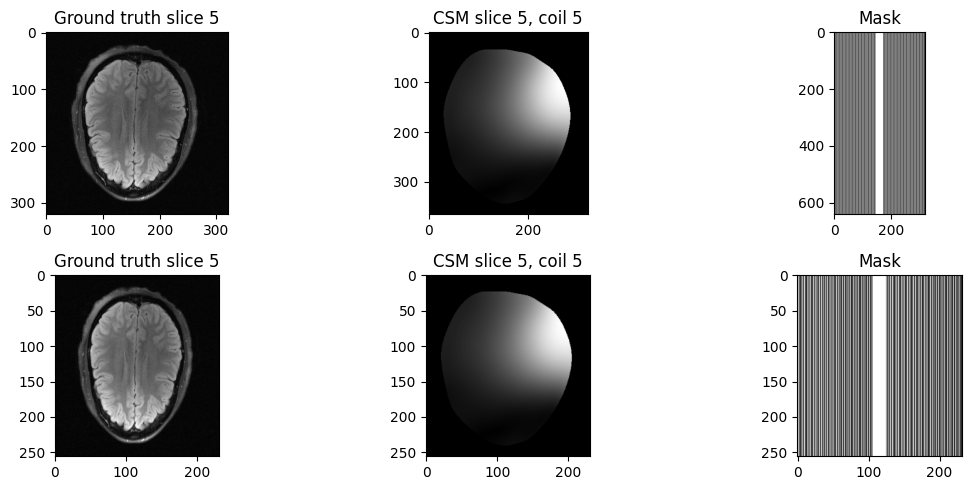

In [220]:
test_file = "csm_file_brain_AXFLAIR_201_6002911.h5"
slice_ = 5
coil = 5
with h5.File("/content/drive/Shareddrives/CIP/train/"+ test_file, 'r') as hf:
  size = (256,232)
  start = 135
  end = 500
  slices, coils, _,_ = hf['trnCsm'][()].shape
  print (hf['trnCsm'][()].shape)
  org, maskk, cms = [[], [], np.empty((slices,coils, *size), dtype = np.complex64)] 
  for i in range(slices):
    org.append(cv2.resize(hf['trnOrg'][i], dsize = size[::-1]))
    maskk.append(cv2.resize(hf['trnMask'][i], dsize = size[::-1]))
    for j in range(coils):
      real =hf['trnCsm'][i,j].real
      imag = hf['trnCsm'][i,j].imag
      cms[i,j] = cv2.resize(np.abs(hf['trnCsm'][i,j][start:end,:]), dsize = size[::-1])#real, dsize = size[::-1]) + 1j*cv2.resize(imag, dsize = size[::-1])

  plt.figure(figsize=(12,5))
  plt.subplot(2,3,1); plt.imshow(np.abs(hf['trnOrg'][slice_]), cmap="gray"); plt.title(f'Ground truth slice {slice_}')
  plt.subplot(2,3,2); plt.imshow(np.abs(hf['trnCsm'][slice_][coil][start:end,:]), cmap="gray"); plt.title(f'CSM slice {slice_}, coil {coil}')
  plt.subplot(2,3,3); plt.imshow(np.abs(hf['trnMask'][slice_]), cmap="gray"); plt.title(f'Mask')
  plt.subplot(2,3,4); plt.imshow(org[slice_], cmap="gray"); plt.title(f'Ground truth slice {slice_}')
  plt.subplot(2,3,5); plt.imshow(np.abs(cms[slice_][coil]), cmap="gray"); plt.title(f'CSM slice {slice_}, coil {coil}')
  plt.subplot(2,3,6); plt.imshow(maskk[slice_], cmap="gray"); plt.title(f'Mask')
  plt.tight_layout() 

  

In [178]:
  folder = "/content/drive/Shareddrives/CIP/crop_train/"
  save(org, cms, maskk, folder + test_file, mode = 'train') 

<HDF5 dataset "trnCsm": shape (14, 20, 640, 320), type "<c8">


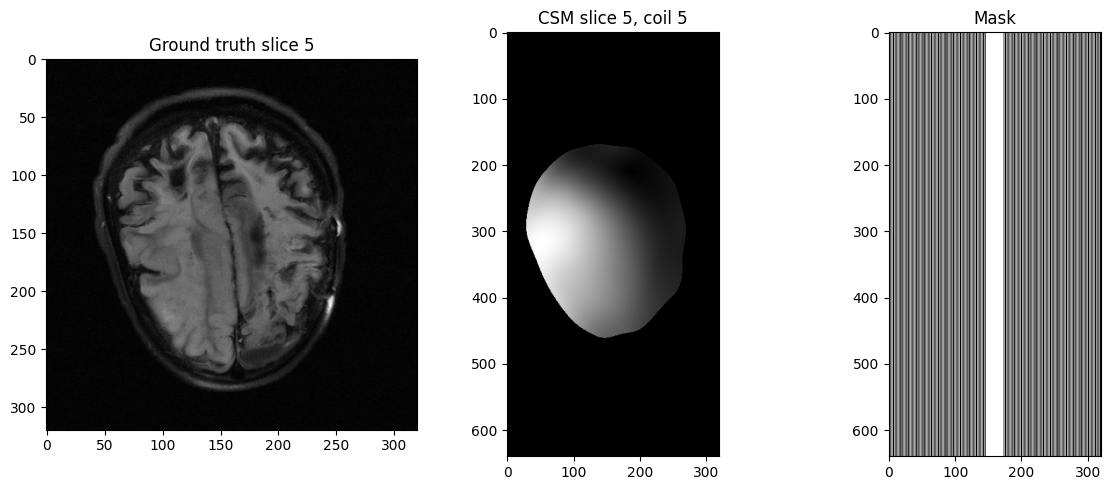

In [ ]:
hf = h5.File('csm_' + orgFilename, 'r')
print(hf['trnCsm'])

slice_ = 5
coil = 5


plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(np.abs(hf['trnOrg'][slice_]), cmap="gray"); plt.title(f'Ground truth slice {slice_}')
plt.subplot(1,3,2); plt.imshow(np.abs(hf['trnCsm'][slice_][coil]), cmap="gray"); plt.title(f'CSM slice {slice_}, coil {coil}')
plt.subplot(1,3,3); plt.imshow(np.abs(hf['trnMask'][slice_]), cmap="gray"); plt.title(f'Mask')

plt.tight_layout() 
hf.close()

In [ ]:
AAAA = np.concatenate((hf['trnOrg'][()], hf['trnOrg'][()]))
AAAA.shape

(28, 320, 320)

In [ ]:
def extract_data_brain_test(orgFilename: str,
               center_fractions = [0.08 ],
               accelerations = [2],# 4
               ):
    path_to_data = '/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_test/'
    f = h5.File(path_to_data + orgFilename, 'r')
    ground_truth = f['reconstruction_rss'][()]
    volume_kspace = f['kspace'][()] # swap channels ?? Answer: No
    csm = []
    
    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
    masks = []


    for slice_kspace in volume_kspace:
        
        # ESPIRiT:
        #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
        c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
        csm.append(c1)
        # Extract Masks
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        _, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        tiled_mask = mask[0,:,:,0] # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))
        masks.append(tiled_mask)#mask.numpy())
    
    csm = np.array(csm)
    masks = np.asarray(masks)  
    name = 'csm_'+orgFilename
    save(ground_truth, csm, masks, name, mode = "test")

In [ ]:
testFile = 'file_brain_AXFLAIR_201_6002868.h5'
extract_data_brain_test(testFile)

## Bringing all together

In [176]:
import os
for filename in os.scandir("/content/drive/Shareddrives/CIP/crop_train/"):
            if filename.is_file():
              with h5.File(filename) as f:
                

<DirEntry 'csm_file_brain_AXFLAIR_201_6002902.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002903.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002906.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002909.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002910.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002911.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002912.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002913.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002914.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002915.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002916.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002917.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002918.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002922.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002923.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002931.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002925.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002933.h5'>
<DirEntry 'csm_file_brain_AXFLAIR_201_6002928.h5'>
<DirEntry 'csm_file_brain_AXFLA

In [215]:
import os
def mergeFiles(target_name:str, directory_train:str = 'trn', directory_test:str = 'tst'):
    with h5.File(target_name, 'w') as target:
        trncsms = None
        trnmasks = None
        trnorgs = None
        tstcsms = None
        tstmasks = None
        tstorgs = None
        for filename in os.scandir(directory_train):
            if filename.is_file():
                with h5.File(filename, 'r') as f:
                    if trncsms is None: # or masks or org
                        trncsms = f['trnCsm'][()]
                        trnmasks = f['trnMask'][()]
                        trnorgs = f['trnOrg'][()]
                    else: 
                        print(filename)
                        trncsms = np.concatenate((trncsms, f['trnCsm'][()]), axis = 0 )
                        trnmasks = np.concatenate((trnmasks, f['trnMask'][()]), axis = 0 ) 
                        trnorgs =  np.concatenate((trnorgs, f['trnOrg'][()]), axis = 0 ) 

        for filename in os.scandir(directory_test):
            if filename.is_file():
                with h5.File(filename, 'r') as f:
                    if tstcsms is None: # or masks or org
                        tstcsms = f['tstCsm'][()]
                        tstmasks = f['tstMask'][()]
                        tstorgs = f['tstOrg'][()]
                    else: 
                        print(filename)
                        tstcsms = np.concatenate((tstcsms, f['tstCsm'][()]), axis = 0 )
                        tstmasks = np.concatenate((tstmasks, f['tstMask'][()]), axis = 0 ) 
                        tstorgs =  np.concatenate((tstorgs, f['tstOrg'][()]), axis = 0 ) 
        target.create_dataset('trnCsm', data = trncsms)    # saves the coil sensitivity maps
        target.create_dataset('trnMask', data = trnmasks)   # is the undersampling mask 
        target.create_dataset('trnOrg', data = trnorgs)  # this is the original ground truth
        target.create_dataset('tstCsm', data = tstcsms)    # saves the coil sensitivity maps
        target.create_dataset('tstMask', data = tstmasks)   # is the undersampling mask 
        target.create_dataset('tstOrg', data = tstorgs) # this is the original ground truth

In [ ]:
target_name = 'datasetCIP.h5'
mergeFiles(target_name, directory_train = "/content/drive/Shareddrives/CIP/crop_train/", directory_test="/content/drive/Shareddrives/CIP/crop_test/") 
    

In [ ]:

with h5.File("/content/drive/Shareddrives/CIP/datasetCIP.h5") as DataModl:
    print(DataModl.keys())
    print(DataModl['tstCsm'].shape)
    print(DataModl['trnMask'])
    print(DataModl['trnOrg'])

    slice_ = 5
    coil = 5


    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1); plt.imshow(np.abs(DataModl['trnOrg'][slice_]), cmap="gray"); plt.title(f'Ground truth slice {slice_}')
    plt.subplot(1,3,2); plt.imshow(np.abs(DataModl['trnCsm'][slice_][coil]), cmap="gray"); plt.title(f'CSM slice {slice_}, coil {coil}')
    plt.subplot(1,3,3); plt.imshow(np.abs(DataModl['trnMask'][slice_]), cmap="gray"); plt.title(f'Mask')

In [ ]:
plt.subplot(1,3,1); plt.imshow(np.abs(hf['trnOrg'][slice_]), cmap="gray"); plt.title(f'Ground truth slice {slice_}')
plt.subplot(1,3,2); plt.imshow(np.abs(hf['trnCsm'][slice_][coil]), cmap="gray"); plt.title(f'CSM slice {slice_}, coil {coil}')
plt.subplot(1,3,3); plt.imshow(np.abs(hf['trnMask'][slice_]), cmap="gray"); plt.title(f'Mask')

# For Knee

In [ ]:
def saveKnee(ground_truth: np.ndarray, csm: np.ndarray, mask: np.ndarray, atb: np.ndarray, name: str):
    with h5.File(name, 'w') as target: # creating a new file containing the necesary data to use it with MoDL
        # order: <KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
        target.create_dataset('atb', data = atb)    # is the aliased/noisy image # It is not necessary for Brain_data
        target.create_dataset('csm', data = csm)    # saves the coil sensitivity maps
        target.create_dataset('mask', data = mask)   # is the undersampling mask 
        target.create_dataset('org', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth

In [ ]:
def extract_data_knee(orgFilename: str,
               center_fractions = [0.08 ],
               accelerations = [2],# 4
               ):
    path_to_data = '/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/multicoil_train/'
    f = h5.File(path_to_data + orgFilename, 'r')
    ground_truth = f['reconstruction_rss'][()]
    volume_kspace = f['kspace'][()] # swap channels ?? Answer: No
    #volume_kspace = np.swapaxes(volume_kspace, 0,1) # uncomment if needed

    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)

    atbs = []
    atbs_before = []
    masks = []
    csm = []

    for slice_kspace in volume_kspace:
        #ESPIRiT:
        #c1 = Espirit(k1, device=sp.Device(0)).run() # CuPy needed (GPU)
        c1 = Espirit(slice_kspace).run() # NO CuPy needed (CPU)
        csm.append(c1)

        # Aliased/Noisy Image (ATB)
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        

        masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        
        # ! we need to replicate the values from axes 1 and 2 mask[0,:,:,0]  -> compare against MoDL's mask
        tiled_mask = mask[0,:,:,0]
        tiled_mask = np.tile(tiled_mask, (slice_kspace2.shape[-3], mask.shape[-1] ))


        sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image


        ## we need complex values -> real and imaginary parts are stored separately...
        sampled_image_complex = sampled_image[:,:,:,0]+1j*sampled_image[:,:,:,1]
        

        ## Apply Root-Sum-of-Squares (RSS) transform.
        sampled_image_rss = fastmri.rss(sampled_image_complex, dim = 0)
        sampled_image_rss_2 = fastmri.rss(np.abs(sampled_image_complex), dim = 0)  # Compute absolute value to get a real image

        ##* Note:  with sampled_image_rss_2 we obtain the same result as with : 
        #sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
        #sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
        

        #sampled_image_rss = np.abs(sampled_image_rss)
        atbs_before.append(sampled_image_rss_2.numpy())
        atbs.append(sampled_image_rss.numpy())
        masks.append(tiled_mask)#mask.numpy())

    csm = np.array(csm)
    masks = np.asarray(masks)  
    name = 'csm_'+orgFilename
    saveKnee(ground_truth, csm, masks, name)